In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
V0 = 0.12
xi = 10.0
m_vals = np.array([-1, 0, 1])
j_max = 20
mass = 1.0
hbar = (1/5)**0.5
E = 2.0
I_0 = 10 # = 2.5       

# Channel indices
j_vals = np.arange(-j_max, j_max + 1)
n_ch = len(j_vals)

# k_j for each channel
k_vals = np.zeros(n_ch, dtype=np.complex128)
for idx, j in enumerate(j_vals):
    val = 2 * mass * (E - ((j ** 2) * (hbar**2) / (2 * I_0)))
    if val >= 0:
        k_vals[idx] = np.sqrt(val)
    else:
        k_vals[idx] = 1j * np.sqrt(-val)

print(f"Channel momenta k_j: {k_vals}")

# Spatial grids
x = np.linspace(-60, 60, 800)
x_prime = np.linspace(-60, 60, 800)


Channel momenta k_j: [0.        +2.j         0.        +1.79443584j 0.        +1.57480157j
 0.        +1.33416641j 0.        +1.05830052j 0.        +0.70710678j
 0.28284271+0.j         0.78740079+0.j         1.05830052+0.j
 1.25698051+0.j         1.41421356+0.j         1.54272486+0.j
 1.64924225+0.j         1.73781472+0.j         1.81107703+0.j
 1.87082869+0.j         1.91833261+0.j         1.95448203+0.j
 1.97989899+0.j         1.99499373+0.j         2.        +0.j
 1.99499373+0.j         1.97989899+0.j         1.95448203+0.j
 1.91833261+0.j         1.87082869+0.j         1.81107703+0.j
 1.73781472+0.j         1.64924225+0.j         1.54272486+0.j
 1.41421356+0.j         1.25698051+0.j         1.05830052+0.j
 0.78740079+0.j         0.28284271+0.j         0.        +0.70710678j
 0.        +1.05830052j 0.        +1.33416641j 0.        +1.57480157j
 0.        +1.79443584j 0.        +2.j        ]


In [26]:
# Incident channel (j=0)
inc_channel = np.where(j_vals == 0)[0][0]

# Initial wavefunctions
psi = np.zeros((n_ch, len(x)), dtype=np.complex128)
psi[inc_channel, :] = np.exp(1j * k_vals[inc_channel] * x)

print(f"Incident channel index: {inc_channel}")
print(f"Initial non-zero channels: {np.where(np.max(np.abs(psi), axis=1) > 1e-10)[0]}")


Incident channel index: 20
Initial non-zero channels: [20]


In [27]:
def compute_potential_matrix(x_p):
    """Compute the Gaussian potential sum"""
    return np.sum([np.exp(-(x_p - m*xi)**2) for m in m_vals])

# Precompute potential for all x_prime points
potential_vals = np.array([compute_potential_matrix(xp) for xp in x_prime])
print(f"Potential values computed for {len(x_prime)} grid points")


Potential values computed for 800 grid points


In [28]:
def next_order_iteration_with_direct_f(psi_prev, f_current, k_vals, inc_channel, energy):
    """
    Optimized Lippmann-Schwinger iteration that directly extracts f coefficients
    during the computation instead of using a separate function
    """   
    psi_next = np.zeros_like(psi_prev)
    
    # Storage for f coefficients: [channel_idx, [reflection, transmission]]
    f_coeffs = np.zeros((n_ch, 2), dtype=np.complex128)
    
    # Loop over channels i (output channels)
    for i_idx, i in enumerate(j_vals):
        
        # Incident wave (only for incident channel)
        if i_idx == inc_channel:
            phi_i = np.exp(1j * k_vals[i_idx] * x)
        else:
            phi_i = np.zeros_like(x)
        
        # Initialize scattered wave components for both regions
        scattered_neg = np.zeros_like(x, dtype=np.complex128)  # x < 0 region
        scattered_pos = np.zeros_like(x, dtype=np.complex128)  # x >= 0 region
        
        # Loop over sgn(x) values: -1 for x < 0, +1 for x >= 0
        for sgn_idx, sgn_x in enumerate([-1, +1]):
            
            # Directly compute psi_{i-1} + psi_{i+1} coupling for channel i
            psi_coupling = np.zeros_like(x_prime, dtype=np.complex128)
            
            # Check if i-1 exists in j_vals and add psi_{i-1}
            if (i - 1) in j_vals:
                idx_minus = np.where(j_vals == (i - 1))[0][0]
                psi_coupling += np.interp(x_prime, x, psi_prev[idx_minus])
            
            # Check if i+1 exists in j_vals and add psi_{i+1}
            if (i + 1) in j_vals:
                idx_plus = np.where(j_vals == (i + 1))[0][0]
                psi_coupling += np.interp(x_prime, x, psi_prev[idx_plus])
            
            # If no coupling channels exist, skip this contribution
            if np.allclose(psi_coupling, 0):
                f_coeffs[i_idx, sgn_idx] = 0.0
                continue
            
            # Phase factor with sgn(x)
            phase_factor = np.exp(-1j * k_vals[i_idx] * x_prime * sgn_x)
            
            # Complete integrand
            integrand = phase_factor * potential_vals * psi_coupling
            
            # Numerical integration over x_prime
            total_integral = np.trapz(integrand, x_prime)
            
            # Apply prefactor - this gives us the f coefficient directly!
            prefactor = -1j * mass * V0 / (hbar**2 * k_vals[i_idx] * 2)
            f_coefficient = prefactor * total_integral
            
            # Store f coefficients directly
            if sgn_x == -1:  # Reflection
                f_coeffs[i_idx, 0] = f_coefficient
                # Apply to x < 0 region
                mask_neg = x < 0
                x_neg = x[mask_neg]
                outgoing_wave_neg = np.exp(-1j * k_vals[i_idx] * x_neg)  # e^(-ikx) for x<0
                scattered_neg[mask_neg] = f_coefficient * outgoing_wave_neg
                
            else:  # sgn_x == +1, Transmission
                f_coeffs[i_idx, 1] = f_coefficient
                # Apply to x >= 0 region
                mask_pos = x >= 0
                x_pos = x[mask_pos]
                outgoing_wave_pos = np.exp(1j * k_vals[i_idx] * x_pos)  # e^(ikx) for x>0
                scattered_pos[mask_pos] = f_coefficient * outgoing_wave_pos
        
        # Combine scattered waves from both regions
        scattered_total = scattered_neg + scattered_pos
        
        # Total wavefunction = incident + scattered
        psi_next[i_idx, :] = phi_i + scattered_total
    
    return psi_next, f_coeffs      


In [29]:
# Run optimized iterative solution
order_max = 25
psi_orders = [psi.copy()]
f_orders = []

# Initialize f coefficients for 0th order (no scattering)
f_initial = np.zeros((n_ch, 2), dtype=np.complex128)
f_orders.append(f_initial)

print("Computing optimized iterations with direct f-coefficient extraction...")
for order in range(1, order_max + 1):
    print(f"Order {order}...")
    psi_new, f_new = next_order_iteration_with_direct_f(psi_orders[-1], f_orders[-1], k_vals, inc_channel, E)
    psi_orders.append(psi_new)
    f_orders.append(f_new)

print(f"Computation completed up to order {order_max}")


Computing optimized iterations with direct f-coefficient extraction...
Order 1...
Order 2...
Order 3...
Order 4...
Order 5...
Order 6...
Order 7...
Order 8...
Order 9...
Order 10...
Order 11...
Order 12...
Order 13...
Order 14...
Order 15...
Order 16...
Order 17...
Order 18...
Order 19...
Order 20...
Order 21...
Order 22...
Order 23...
Order 24...
Order 25...
Computation completed up to order 25


In [30]:
# Results display
print("\n" + "="*70)
print("OPTIMIZED RESULTS WITH DIRECT F-COEFFICIENT EXTRACTION")
print("="*70)

for order in range(order_max + 1):
    print(f"\nORDER {order}:")
    print("-" * 30)
    
    # Display f coefficients directly computed during iteration
    f_vals = f_orders[order]
    for i_idx, j in enumerate(j_vals):
        print(f"Channel {j:2d}: Reflection = {f_vals[i_idx,0]:12.6f}, Transmission = {f_vals[i_idx,1]:12.6f}")



OPTIMIZED RESULTS WITH DIRECT F-COEFFICIENT EXTRACTION

ORDER 0:
------------------------------
Channel -20: Reflection = 0.000000+0.000000j, Transmission = 0.000000+0.000000j
Channel -19: Reflection = 0.000000+0.000000j, Transmission = 0.000000+0.000000j
Channel -18: Reflection = 0.000000+0.000000j, Transmission = 0.000000+0.000000j
Channel -17: Reflection = 0.000000+0.000000j, Transmission = 0.000000+0.000000j
Channel -16: Reflection = 0.000000+0.000000j, Transmission = 0.000000+0.000000j
Channel -15: Reflection = 0.000000+0.000000j, Transmission = 0.000000+0.000000j
Channel -14: Reflection = 0.000000+0.000000j, Transmission = 0.000000+0.000000j
Channel -13: Reflection = 0.000000+0.000000j, Transmission = 0.000000+0.000000j
Channel -12: Reflection = 0.000000+0.000000j, Transmission = 0.000000+0.000000j
Channel -11: Reflection = 0.000000+0.000000j, Transmission = 0.000000+0.000000j
Channel -10: Reflection = 0.000000+0.000000j, Transmission = 0.000000+0.000000j
Channel -9: Reflection 

In [31]:
def plot_order_results(order):
    """Plot results for a specific order"""
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Real parts
    plt.subplot(1, 3, 1)
    for j_idx, j in enumerate(j_vals):
        if np.max(np.abs(psi_orders[order][j_idx])) > 1e-10:
            plt.plot(x, psi_orders[order][j_idx].real, label=f'Channel {j}', linewidth=2)
    
    plt.title(f'Real Part - Order {order}')
    plt.xlabel('x')
    plt.ylabel('Re(ψ_j(x))')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Imaginary parts
    plt.subplot(1, 3, 2)
    for j_idx, j in enumerate(j_vals):
        if np.max(np.abs(psi_orders[order][j_idx])) > 1e-10:
            plt.plot(x, psi_orders[order][j_idx].imag, label=f'Channel {j}', linewidth=2)
    
    plt.title(f'Imaginary Part - Order {order}')
    plt.xlabel('x')
    plt.ylabel('Im(ψ_j(x))')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: F-coefficients magnitude
    plt.subplot(1, 3, 3)
    f_vals = f_orders[order]
    channels = j_vals
    reflection_mags = np.abs(f_vals[:, 0])
    transmission_mags = np.abs(f_vals[:, 1])
    
    width = 0.35
    x_pos = np.arange(len(channels))
    
    plt.bar(x_pos - width/2, reflection_mags, width, label='|Reflection|', alpha=0.7)
    plt.bar(x_pos + width/2, transmission_mags, width, label='|Transmission|', alpha=0.7)
    
    plt.title(f'|f coefficients| - Order {order}')
    plt.xlabel('Channel j')
    plt.ylabel('|f_{i,j}|')
    plt.xticks(x_pos, channels)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [ ]:
# Generate plots for all orders
for order in range(order_max + 1):
    plot_order_results(order)


In [33]:
j_max = 6
j_vals = np.arange(-j_max, j_max + 1)
order_max = 6

In [34]:
def calculate_all_f_coefficients(k_vals, n_ch, order_max, E, x, j_vals):
    
    all_f_coeffs = {}
    
    for inc_channel in range(len(j_vals)):
        if np.imag(k_vals[inc_channel]) < 1e-10:  # Only open channels
            
            # Initialize for this incident channel
            psi = np.zeros((n_ch, len(x)), dtype=np.complex128)  # You'll need to define x grid
            psi[inc_channel, :] = np.exp(1j * k_vals[inc_channel] * x)
            psi_orders = [psi.copy()]
            f_orders = []
            
            # Initialize f coefficients for 0th order (no scattering)
            f_initial = np.zeros((n_ch, 2), dtype=np.complex128)
            f_orders.append(f_initial)
            
            print(f"Computing for incident channel {inc_channel}... (j_val = {j_vals[inc_channel]})...")
            for order in range(1, order_max + 1):
                psi_new, f_new = next_order_iteration_with_direct_f(
                    psi_orders[-1], f_orders[-1], k_vals, inc_channel, E
                )
                psi_orders.append(psi_new)
                f_orders.append(f_new)
            
            all_f_coeffs[inc_channel] = f_orders[-1]
    
    return all_f_coeffs


In [35]:
all_f_coeffs = calculate_all_f_coefficients(k_vals, n_ch, order_max, E, x, j_vals)

Computing for incident channel 6... (j_val = 0)...
Computing for incident channel 7... (j_val = 1)...
Computing for incident channel 8... (j_val = 2)...
Computing for incident channel 9... (j_val = 3)...
Computing for incident channel 10... (j_val = 4)...
Computing for incident channel 11... (j_val = 5)...
Computing for incident channel 12... (j_val = 6)...


In [36]:
def construct_full_s_matrix(all_f_coeffs, k_vals):
    """
    Construct the full 2N×2N S-matrix from f-coefficients
    
    Parameters:
    - all_f_coeffs: dict with keys inc_channel and values f_coeff arrays
    - k_vals: momentum values for each channel
    
    Returns:
    - S_matrix: 2N x 2N complex numpy array
    """
    # Get open channel indices
    open_channel_indices = [i for i in range(len(j_vals)) if np.imag(k_vals[i]) < 1e-10]
    n_open_channels = len(open_channel_indices)
    
    # Initialize S-matrix
    S_matrix = np.zeros((2*n_open_channels, 2*n_open_channels), dtype=np.complex128)
    
    # Fill the S-matrix
    for i, inc_channel in enumerate(open_channel_indices):
        f_coeffs = all_f_coeffs[inc_channel]
        
        for j, out_channel in enumerate(open_channel_indices):
            # Extract reflection and transmission coefficients
            r_coeff = f_coeffs[out_channel, 0]  # reflection coefficient
            t_coeff = f_coeffs[out_channel, 1]  # transmission coefficient
            
            # Fill the 2×2 block for this channel pair
            # Structure: (t_ij  r_ij)
            #           (r_ij  t_ij)
            S_matrix[2*j, 2*i] = t_coeff      # t_ij
            S_matrix[2*j, 2*i+1] = r_coeff    # r_ij  
            S_matrix[2*j+1, 2*i] = r_coeff    # r_ij
            S_matrix[2*j+1, 2*i+1] = t_coeff  # t_ij
    
    return S_matrix


In [37]:
all_f_coeffs = calculate_all_f_coefficients(k_vals, n_ch, order_max, E, x , j_vals)

# Construct the full S-matrix
S_matrix = construct_full_s_matrix(all_f_coeffs, k_vals)

# Verify unitarity and print eigenvalues
S_dagger_S = np.conj(S_matrix.T) @ S_matrix
unitarity_check = np.max(np.abs(S_dagger_S - np.eye(S_matrix.shape[0])))

eigenvalues = np.linalg.eigvals(S_matrix)

print(f"S-matrix shape: {S_matrix.shape}")
print(f"Unitarity check (should be ~0): {unitarity_check}")
print(f"S-matrix eigenvalues: {eigenvalues}")
print(f"Eigenvalue magnitudes: {np.abs(eigenvalues)}")


Computing for incident channel 6... (j_val = 0)...
Computing for incident channel 7... (j_val = 1)...
Computing for incident channel 8... (j_val = 2)...
Computing for incident channel 9... (j_val = 3)...
Computing for incident channel 10... (j_val = 4)...
Computing for incident channel 11... (j_val = 5)...
Computing for incident channel 12... (j_val = 6)...
S-matrix shape: (14, 14)
Unitarity check (should be ~0): 7.916271666184675e+18
S-matrix eigenvalues: [ 1.60767624e+09+3.63977099e+09j  7.54382285e+05+1.73570904e+06j
  3.69329124e+06-4.82213937e+05j -4.56649505e+04-3.71014008e+04j
 -5.59745782e-01-3.76417091e-01j -3.81386574e-01-8.80301462e-01j
 -2.27293753e-01-5.78931026e-01j -2.88315024e-01+7.58530685e-01j
 -3.54754136e-01+6.47610630e-01j -3.78696625e-02-3.82496051e-01j
 -3.27519588e-02-2.06351025e-01j -2.24162994e-02+4.36583390e-02j
 -1.63967755e-02+2.68136387e-01j -5.02795376e-02+3.18829441e-01j]
Eigenvalue magnitudes: [3.97901442e+09 1.89255872e+06 3.72463830e+06 5.88370771e+04

Computing for incident channel 6... (j_val = 0)...
Computing for incident channel 7... (j_val = 1)...
Computing for incident channel 8... (j_val = 2)...
Computing for incident channel 9... (j_val = 3)...
Computing for incident channel 10... (j_val = 4)...
Computing for incident channel 11... (j_val = 5)...
Computing for incident channel 12... (j_val = 6)...


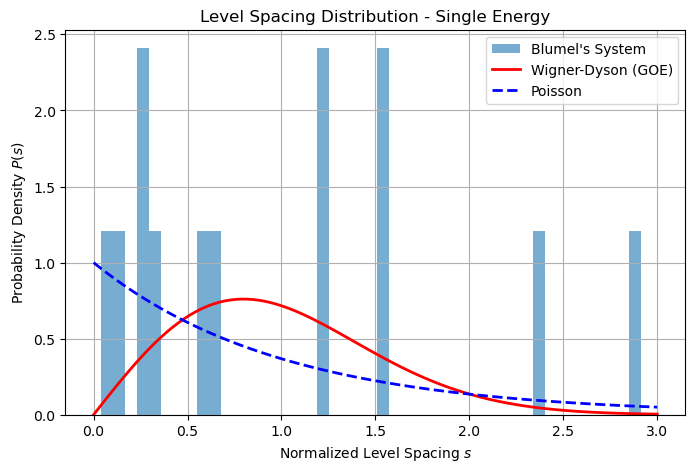

In [38]:
def single_energy_level_statistics(E, k_vals, j_vals, x, n_ch, order_max):
    """
    Calculate level statistics from S-matrix eigenphases at single energy
    """
    # Calculate f-coefficients for all channels at this energy
    all_f_coeffs = calculate_all_f_coefficients(k_vals, n_ch, order_max, E, x, j_vals)
    
    # Construct S-matrix
    S_matrix = construct_full_s_matrix(all_f_coeffs, k_vals)
    
    # Get eigenvalues and extract phases
    eigenvalues = np.linalg.eigvals(S_matrix)
    phases = np.angle(eigenvalues)
    
    # Sort phases and calculate spacings
    sorted_phases = np.sort(phases)
    spacings = np.diff(sorted_phases)
    
    # Normalize spacings
    mean_spacing = np.mean(spacings)
    normalized_spacings = spacings / mean_spacing
    
    return normalized_spacings, S_matrix

# Usage
normalized_spacings, S_matrix = single_energy_level_statistics(
    E=2.0, k_vals=k_vals, j_vals=j_vals, x=x, n_ch=n_ch, order_max=20
)

# Plot histogram and compare with theory
import matplotlib.pyplot as plt

s_vals = np.linspace(0, 3, 100)
wigner_dyson = (np.pi/2) * s_vals * np.exp(-np.pi * s_vals**2 / 4)
poisson = np.exp(-s_vals)

plt.figure(figsize=(8, 5))
plt.hist(normalized_spacings, bins=45, density=True, alpha=0.6, label='Blumel\'s System')
plt.plot(s_vals, wigner_dyson, 'r-', lw=2, label='Wigner-Dyson (GOE)')
plt.plot(s_vals, poisson, 'b--', lw=2, label='Poisson')
plt.xlabel('Normalized Level Spacing $s$')
plt.ylabel('Probability Density $P(s)$')
plt.title('Level Spacing Distribution - Single Energy')
plt.legend()
plt.grid(True)
plt.show()
